In [18]:
%load_ext autoreload
%autoreload 2
from geolifeclef.utils import get_spark
from pyspark.sql import functions as F

spark = get_spark()
data_root = "/mnt/data/geolifeclef-2024/data"


df = spark.read.parquet(
    f"{data_root}/models/xgboost_multilabel_dct_cpu_2/v1/predictions/predictions"
).cache()
df.printSchema()
df.show(vertical=True, n=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


24/04/24 04:37:36 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


root
 |-- surveyId: integer (nullable = true)
 |-- lat_proj: double (nullable = true)
 |-- lon_proj: double (nullable = true)
 |-- labels: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- dataset: string (nullable = true)
 |-- is_validation: boolean (nullable = true)
 |-- labels_dct_sliced: vector (nullable = true)
 |-- label_000: double (nullable = true)
 |-- label_001: double (nullable = true)
 |-- prediction_000: double (nullable = true)
 |-- prediction_001: double (nullable = true)
 |-- dct_prediction: vector (nullable = true)
 |-- prediction: array (nullable = true)
 |    |-- element: double (containsNull = true)



-RECORD 0---------------------------------
 surveyId          | 10060                
 lat_proj          | -1532678.9260912032  
 lon_proj          | 1.690041273597241E7  
 labels            | [96.0, 540.0, 890... 
 dataset           | pa_train             
 is_validation     | false                
 labels_dct_sliced | [0.28277987948206... 
 label_000         | 0.28277987948206884  
 label_001         | 0.047118112186339364 
 prediction_000    | 0.12625212967395782  
 prediction_001    | -0.00795074366033... 
 dct_prediction    | [0.12625212967395... 
 prediction        | []                   
only showing top 1 row



In [19]:
top = df.select("labels", "labels_dct_sliced", "dct_prediction").limit(100).toPandas()
top

,labels,labels_dct_sliced,dct_prediction
0,"[96.0, 540.0, 890.0, 1018.0, 1545.0, 1910.0, 2...","[0.28277987948206884, 0.047118112186339364]","[0.12625212967395782, -0.007950743660330772]"
1,"[129.0, 254.0, 540.0, 649.0, 896.0, 1180.0, 13...","[0.18851991965471257, 0.1009386113866661]","[0.08394297957420349, -0.009561450220644474]"
2,"[3581.0, 7817.0, 7978.0, 10255.0, 10600.0, 109...","[0.056555975896413785, -0.047780687683981776]","[0.08022013306617737, -0.012071873061358929]"
3,"[340.0, 581.0, 694.0, 2608.0, 2703.0, 2922.0, ...","[0.254501891533862, 0.004606947706975041]","[0.013587220571935177, 0.0006521610193885863]"
4,"[868.0, 3958.0, 4341.0, 5148.0, 5181.0, 6707.0...","[0.1036859558100919, -0.01737445898381113]","[0.011170722544193268, 2.4019038391998038e-05]"
...,...,...,...
95,"[3123.0, 3488.0, 4027.0, 4541.0, 5285.0, 5526....","[0.18851991965471257, 0.005485863697078981]","[0.12133974581956863, -0.01031714677810669]"
96,"[540.0, 544.0, 694.0, 981.0, 1475.0, 1539.0, 1...","[0.2356498995683907, 0.03204938097873524]","[0.013722010888159275, 0.0006733182235620916]"
97,"[1539.0, 1795.0, 2025.0, 2813.0, 4609.0, 5900....","[0.13196394375829879, 0.014833761004368704]","[0.052002906799316406, -0.008633911609649658]"
98,"[433.0, 540.0, 958.0, 1951.0, 2885.0, 3123.0, ...","[0.1602419317065057, 0.07354044196306322]","[0.07068837434053421, 0.0001546246639918536]"


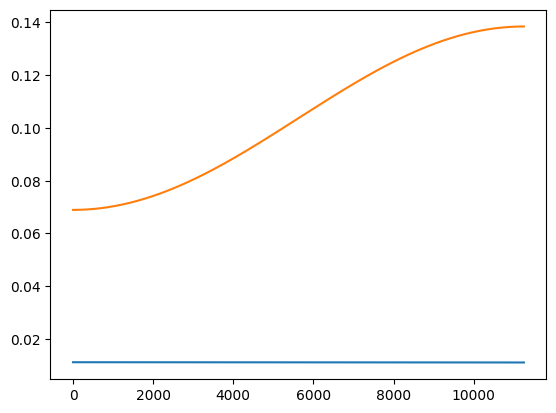

In [28]:
# invert dct and see what the results look like
from scipy.fftpack import idct, dct
import numpy as np
import matplotlib.pyplot as plt

row = top.iloc[4]
n = 11255
x_pred = row.dct_prediction
x = row.labels_dct_sliced

x_pred_full = np.zeros(n)
x_pred_full[: len(x_pred)] = x_pred
x_full = np.zeros(n)
x_full[: len(x)] = x

plt.plot(idct(x_pred_full))
plt.plot(idct(x_full))
plt.show()

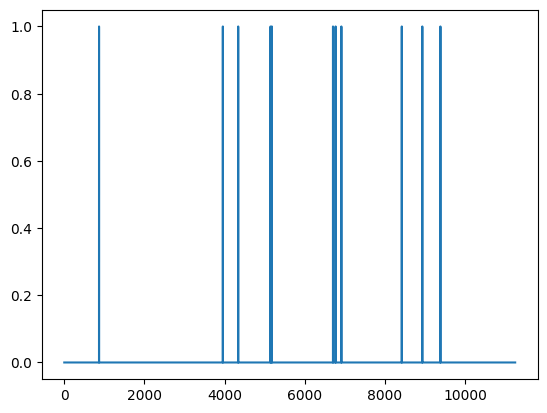

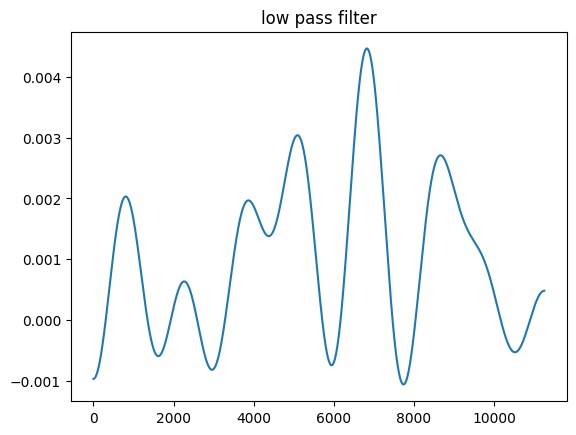

Text(0.5, 1.0, 'high pass filter')

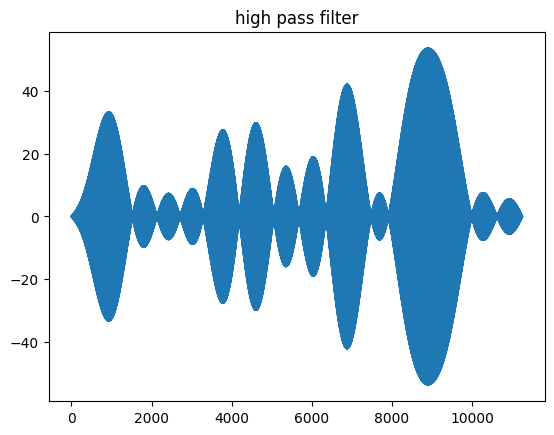

In [36]:
# convert this into a sparse array so we can compute the dct
# each element in our labels array is an index into the sparse matrix
x = np.zeros(n)
for i in row.labels:
    x[int(i)] = 1
plt.plot(x)
plt.show()

k = 16
# use the dct to filter top coefficient
x_dct = dct(x, norm="ortho")
x_dct[k:] = 0
x_filtered = idct(x_dct, norm="ortho")
plt.plot(x_filtered)
plt.title("low pass filter")
plt.show()

# same but high pass filter
x_dct = dct(x)
x_dct[:-k] = 0
x_filtered = idct(x_dct)
plt.plot(x_filtered)
plt.title("high pass filter")